In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
from pathlib import Path
from collections import Counter, defaultdict
from PIL import Image

In [2]:
try:
    import google.colab
    from google.colab import drive

    !uv pip install anomalib
    !uv pip install open-clip-torch
    !uv pip install qwen-vl-utils
    !uv pip install transformers==4.52.4
    !uv pip install langchain-chroma langchain-huggingface
    !uv pip install langchain_community pypdf beautifulsoup4

    drive.mount('/content/drive', force_remount=True)

    # Colab Root
    PROJECT_ROOT = Path('/content/drive/Othercomputers/Mac/multiModal_anomaly_report') # 본인 경로 수정: Mac/Window
    DATA_ROOT = PROJECT_ROOT / "dataset" / "MMAD"

except ImportError:

    # Local Root
    PROJECT_ROOT = Path.cwd().parents[1]
    DATA_ROOT = PROJECT_ROOT / "datasets" / "MMAD"

os.chdir(PROJECT_ROOT) # 현재 경로 수정
print(f"Current working directory: {os.getcwd()}")

Using Python 3.12.12 environment at: /usr
Audited 1 package in 103ms
Using Python 3.12.12 environment at: /usr
Audited 1 package in 94ms
Using Python 3.12.12 environment at: /usr
Audited 1 package in 91ms
Using Python 3.12.12 environment at: /usr
Audited 1 package in 93ms
Using Python 3.12.12 environment at: /usr
Audited 2 packages in 97ms
Using Python 3.12.12 environment at: /usr
Audited 3 packages in 94ms
Mounted at /content/drive
Current working directory: /content/drive/Othercomputers/Mac/multiModal_anomaly_report


### Load Json

In [3]:
from src.utils import load_json

# Json path
DOMAIN_KNOWLEDGE_ROOT = DATA_ROOT / "domain_knowledge.json"

domain_knowledge = load_json(DOMAIN_KNOWLEDGE_ROOT)
target_datasets = ["GoodsAD", "MVTec-LOCO"]
knowledge = {k: v for k, v in domain_knowledge.items() if k in target_datasets}
knowledge['GoodsAD']['cigarette_box']

{'good': ' <Normal Characteristics>\n Description: The cigarette boxes displayed in the images exhibit standard characteristics for packaging in this product category. Each box maintains a consistent form and structure, featuring intact edges and corners without any visible tears, dents, or distortions. The color schemes are typically vibrant and aligned with brand specifications, incorporating decorative elements, logos, and text that are clear, sharp, and properly positioned. The design patterns are symmetrical and consistent across the various boxes, with no signs of misprinting or irregular graphics. Minor noise features such as reflections, shadows, and slight variations in color due to lighting conditions are present, but these do not detract from the overall quality and presentation of the boxes. The packaging appears well-preserved, suitable for retail display, and in line with expected standards for cigarette products.',
 'opened': ' <Packaging Tampering>\n Description: The de

In [4]:
rows = []
for dataset, categories in knowledge.items():
    for category, defects in categories.items():
        for defect_type, desc in defects.items():
            rows.append({
                "dataset": dataset,
                "category": category,
                "defect_type": defect_type,
                "description": desc.strip(),
                "char_len": len(desc.strip()),
            })

df = pd.DataFrame(rows)
df

,dataset,category,defect_type,description,char_len
0,MVTec-LOCO,pushpins,good,<Normal Characteristics>\n Description: The pu...,847
1,MVTec-LOCO,pushpins,structural_anomalies,<Structural Anomaly>\n Description: The pushpi...,632
2,MVTec-LOCO,pushpins,logical_anomalies,<Logical Anomaly: Missing or Additional Pushpi...,1030
3,MVTec-LOCO,breakfast_box,good,<Normal Characteristics>\n Description: The br...,937
4,MVTec-LOCO,breakfast_box,structural_anomalies,<Fruit Damage and Contamination>\n Description...,828
5,MVTec-LOCO,breakfast_box,logical_anomalies,<Logical Anomalies>\n Description: The common ...,1069
6,MVTec-LOCO,screw_bag,good,<Normal Characteristics>\n Description: The in...,835
7,MVTec-LOCO,screw_bag,structural_anomalies,<Structural Anomaly>\n Description: The items ...,1196
8,MVTec-LOCO,screw_bag,logical_anomalies,<Logical Anomaly in Hardware Sets>\n Descripti...,1182
9,MVTec-LOCO,juice_bottle,good,<Normal Characteristics>\n Description: The in...,892


### Description length distribution

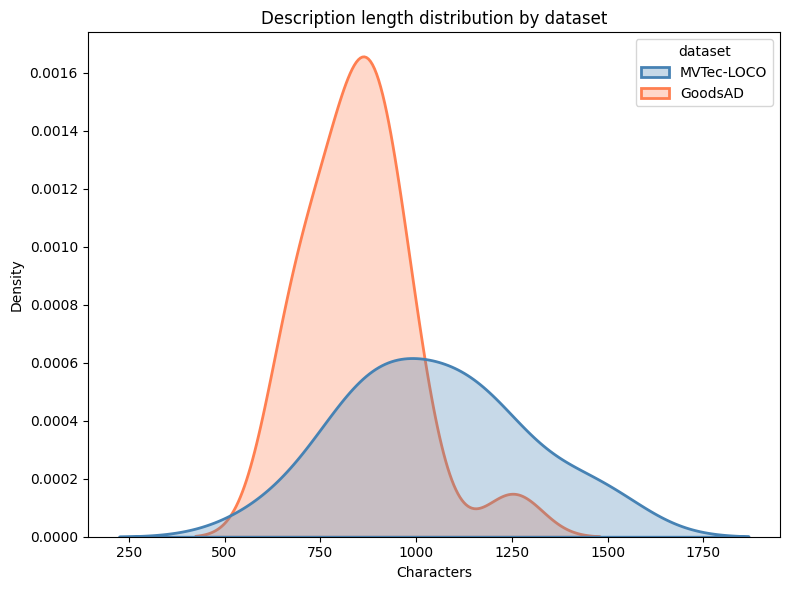

<Axes: title={'center': 'Description length distribution by dataset'}, xlabel='Characters', ylabel='Density'>

In [5]:
from src.visual.plot import *

kde_plot(df, col="char_len", hue="dataset", figsize=(8, 6),
           title="Description length distribution by dataset",
           xlabel="Characters",
           palette=["steelblue", "coral"])

### Defect types Counts

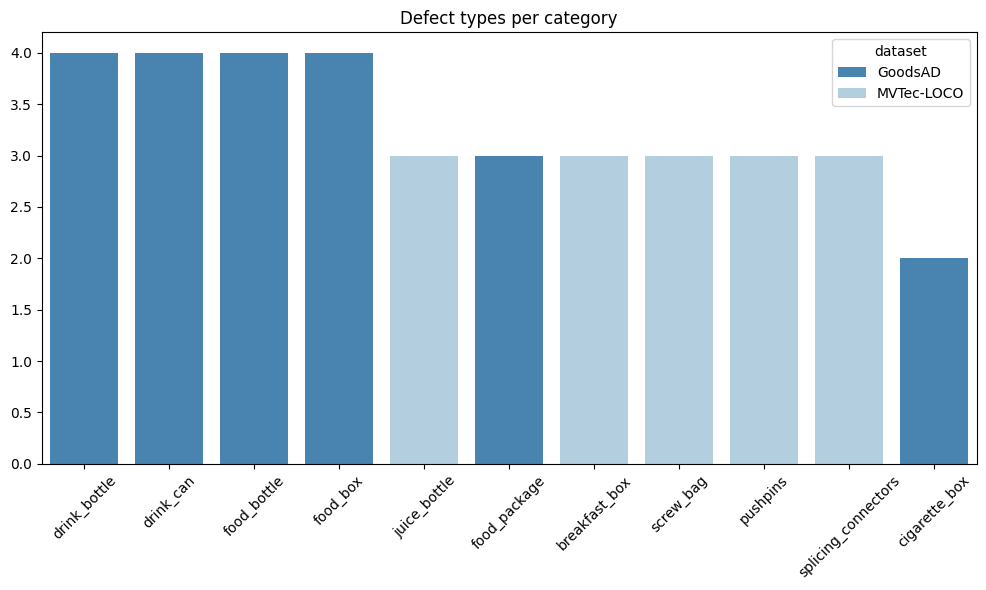

<Axes: title={'center': 'Defect types per category'}>

In [6]:
defect_counts = df.groupby(["dataset", "category"])["defect_type"].count().reset_index(name="count")
defect_counts = defect_counts.sort_values(by=['count'], ascending=False).reset_index(drop=True)
bar_plot(defect_counts, x_col="category", y_col="count", hue="dataset",
        title="Defect types per category", rotation=45)

/content/drive/Othercomputers/Mac/multiModal_anomaly_report/src/visual/plot.py:150: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=hue, y=col, palette=palette, ax=ax)


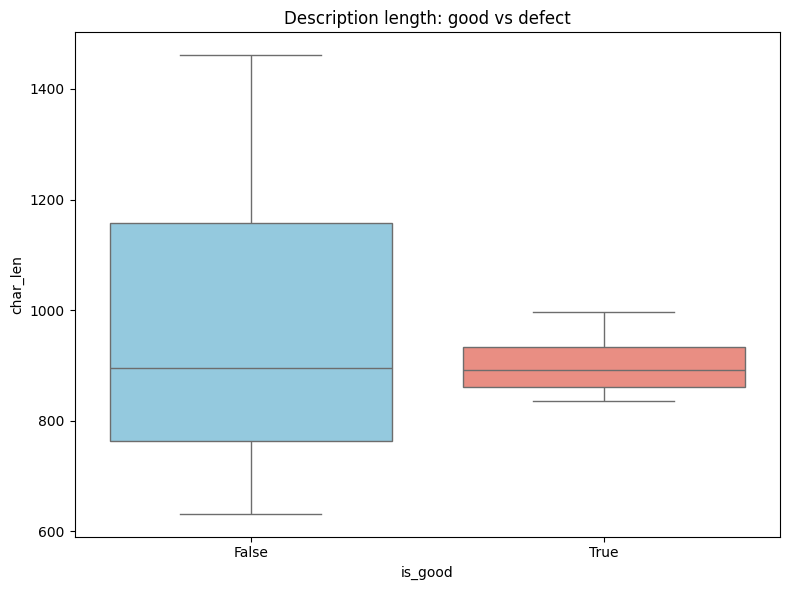

<Axes: title={'center': 'Description length: good vs defect'}, xlabel='is_good', ylabel='char_len'>

In [7]:
df["is_good"] = df["defect_type"] == "good"
box_plot(df, col="char_len", hue="is_good",
        title="Description length: good vs defect")

### Chart Len

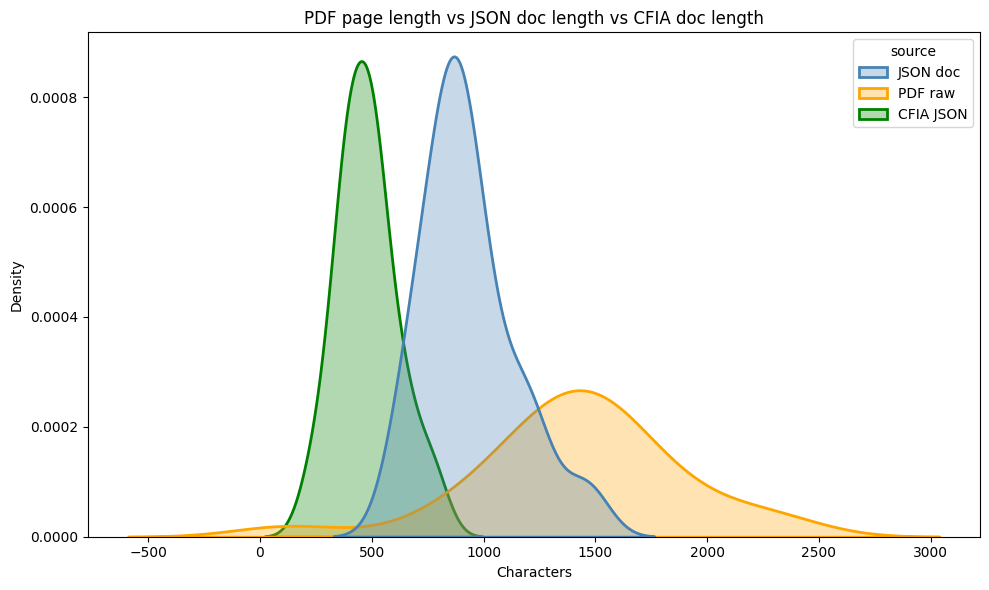

Json Max Len: 1461
Json Min Len: 632

PDF  Max Len: 2319
PDF  Min Len: 130

CFIA Max Len: 787
CFIA Min Len: 229


In [8]:
from langchain_community.document_loaders import PyPDFLoader
from src.rag.loaders import JSONKnowledgeLoader

PDF_PATH = DATA_ROOT / "packaging_guide.pdf"
raw_pages = PyPDFLoader(str(PDF_PATH)).load()
pdf_lens = [len(p.page_content) for p in raw_pages if len(p.page_content) > 100]
pdf_df = pd.DataFrame({"char_len": pdf_lens, "source": "PDF raw"})
json_df = df[["char_len"]].assign(source="JSON doc")

CFIA_JSON_PATH = DATA_ROOT / "cfia_knowledge.json"
cfia_doc = JSONKnowledgeLoader(CFIA_JSON_PATH).load()

cfia_rows = []
for doc in cfia_doc:
        cfia_rows.append({
                "dataset":     doc.metadata.get("dataset", ""),
                "category":    doc.metadata.get("category", ""),
                "defect_type": doc.metadata.get("defect_type", ""),
                "description": doc.page_content,
                "char_len":    len(doc.page_content),
        })
cfia_df = pd.DataFrame(cfia_rows)
cfia_len_df = cfia_df[["char_len"]].assign(source="CFIA JSON")

combined = pd.concat([json_df, pdf_df, cfia_len_df])

kde_plot(combined, col="char_len", hue="source",
        title="PDF page length vs JSON doc length vs CFIA doc length",
        xlabel="Characters", palette=["steelblue", "orange", "green"])

print(f"Json Max Len: {json_df['char_len'].max()}")
print(f"Json Min Len: {json_df['char_len'].min()}\n")
print(f"PDF  Max Len: {pdf_df['char_len'].max()}")
print(f"PDF  Min Len: {pdf_df['char_len'].min()}\n")
print(f"CFIA Max Len: {cfia_df['char_len'].max()}")
print(f"CFIA Min Len: {cfia_df['char_len'].min()}")

In [9]:
from src.rag.loaders import PDFKnowledgeLoader, JSONKnowledgeLoader

PDF_PATH = DATA_ROOT / "packaging_guide.pdf"
pdf_loader = PDFKnowledgeLoader(pdf_path=PDF_PATH, chunk_size=1000, chunk_overlap=100)
pdf_docs = pdf_loader.load()
print(f"총 {len(pdf_docs)}개 chunks")

CFIA_JSON_PATH = DATA_ROOT / "cfia_knowledge.json"
cfia_docs = JSONKnowledgeLoader(CFIA_JSON_PATH).load()
print(f"총 {len(cfia_docs)}개 docs")

총 20개 chunks
총 26개 docs


In [10]:
from src.rag import Indexer, Retrievers, PDFKnowledgeLoader, JSONKnowledgeLoader
import shutil

# pdf test
shutil.rmtree("vectorstore/test_pdf", ignore_errors=True)
vs_pdf = Indexer(persist_dir="vectorstore/test_pdf").build_index_from(pdf_docs)
retriever_pdf = Retrievers(vs_pdf)

docs = retriever_pdf.retrieve("포장 씰에 이물질이 끼어있어요", k=3)
for doc in docs:
    print(doc.metadata)
    print(doc.page_content[:150], "\n")


{'page_label': '6', 'source_type': 'pdf', 'source': '/content/drive/Othercomputers/Mac/multiModal_anomaly_report/dataset/MMAD/packaging_guide.pdf', 'creator': 'PyPDF', 'total_pages': 24, 'creationdate': '', 'producer': 'PyPDF', 'dataset': 'PackagingGuide', 'category': 'food_bottle', 'page': 6, 'defect_type': 'tamper_safety_seal'}
Tamper Proof and Safety Seal Inspection
Challenge
Tamper proof packaging has become a universally adopted safety 
practice in the CPG and food and bev 

{'page': 7, 'page_label': '7', 'defect_type': 'contamination_foreign', 'creator': 'PyPDF', 'category': 'food_package', 'total_pages': 24, 'source_type': 'pdf', 'dataset': 'PackagingGuide', 'creationdate': '', 'producer': 'PyPDF', 'source': '/content/drive/Othercomputers/Mac/multiModal_anomaly_report/dataset/MMAD/packaging_guide.pdf'}
Contamination or Foreign Material Inspection
Challenge
Contamination and foreign material, such as air pockets, dust, 
particles, or hair, are still o 

{'source_type': 'pdf', 'pr

In [11]:
shutil.rmtree("vectorstore/test_cfia", ignore_errors=True)
vs_cfia = Indexer(persist_dir="vectorstore/test_cfia").build_index_from(cfia_docs)
retriever_cfia = Retrievers(vs_cfia)

docs = retriever_cfia.retrieve("포장 씰에 이물질이 끼어있어요", k=3)
for doc in docs:
    print(doc.metadata)
    print(doc.page_content[:150], "\n")

{'source_type': 'json', 'category': 'food_package', 'defect_type': 'wrinkle', 'dataset': 'CFIA_RetortPouch'}
Classification: Serious if the fold in the seal area leaves less than 3 mm continuous acceptable seal, or the fold-over wrinkle extends through all pl 

{'dataset': 'CFIA_RetortPouch', 'source_type': 'json', 'defect_type': 'compressed_seal', 'category': 'food_package'}
Classification: Serious if there is visual evidence of seal overheating (such as bubbles or exposed foil) and less than 3 mm of continuous good seal r 

{'dataset': 'CFIA_RetortPouch', 'category': 'food_package', 'defect_type': 'incomplete_seal', 'source_type': 'json'}
Classification: Serious defect. Description: The seal area does not extend completely across the width of the pouch. This defect can be detected visua 



In [12]:
docs_pdf = retriever_pdf.retrieve("foreign material contamination in seal area", k=3)
print("\n=== PDF 영어 쿼리 ===")
for doc in docs_pdf:
    print(f"  {doc.metadata['defect_type']}")

docs_cfia = retriever_cfia.retrieve("foreign material contamination in seal area", k=3)
print("\n=== CFIA 영어 쿼리 ===")
for doc in docs_cfia:
    print(f"  {doc.metadata['defect_type']}")


=== PDF 영어 쿼리 ===
  seal_void_fold
  contamination_foreign
  tamper_safety_seal

=== CFIA 영어 쿼리 ===
  contaminated_seal
  less_than_3mm_seal_width
  notch_leaker


In [13]:
indexer = Indexer(
    json_path=DOMAIN_KNOWLEDGE_ROOT,
    persist_dir="vectorstore/domain_knowledge",
    embedding_provider="huggingface",
)

vectorstore = indexer.get_or_create()
print(f"Documents indexed: {vectorstore._collection.count()}")

retriever = Retrievers(vectorstore)
docs = retriever.retrieve("제품 표면에 긁힌 자국이 있고 색이 변했어요", dataset=["GoodsAD", "MVTec-LOCO"], k=3)
for doc in docs:
    print(doc.metadata)
    print(doc.page_content[:100], "\n")

Documents indexed: 146
{'defect_type': 'opened', 'category': 'cigarette_box', 'dataset': 'GoodsAD'}
<Packaging Tampering>
 Description: The defect involves an alteration in the packaging integrity of  

{'category': 'food_box', 'dataset': 'GoodsAD', 'defect_type': 'surface_damage'}
<Surface Damage>
 Description: The defect appears as a variety of surface irregularities found on th 

{'defect_type': 'opened', 'category': 'food_bottle', 'dataset': 'GoodsAD'}
<Compromised Seal/Opened Packaging>
 Description: The defect appears as an opening, tear, or irregul 



In [14]:
from src.rag import Indexer, Retrievers, RAGEvaluator, TEST_QUERIES_MMAD, TEST_QUERIES_EXTERNAL
import shutil

# Config A: JSON only
indexers = Indexer(
    json_path=DOMAIN_KNOWLEDGE_ROOT,
    persist_dir="vectorstore/domain_knowledge"
)
vs_config = indexers.get_or_create()
domain_docs = indexers.load_documents()

# Config B: JSON + PDF
shutil.rmtree("vectorstore/domain_knowledge_pdf", ignore_errors=True)
vs_config_pdf = Indexer(
    persist_dir="vectorstore/domain_knowledge_pdf"
).build_index_from(domain_docs + pdf_docs)

# Config C: JSON + CFIA
shutil.rmtree("vectorstore/domain_knowledge_cfia", ignore_errors=True)
vs_config_cfia = Indexer(
    persist_dir="vectorstore/domain_knowledge_cfia"
).build_index_from(domain_docs + cfia_docs)

# Config D: JSON + PDF + CFIA
shutil.rmtree("vectorstore/domain_knowledge_pdf_cfia", ignore_errors=True)
vs_config_pdf_cfia = Indexer(
    persist_dir="vectorstore/domain_knowledge_pdf_cfia"
).build_index_from(domain_docs + pdf_docs + cfia_docs)

print(f"Config A : {vs_config._collection.count():>4} docs")
print(f"Config B : {vs_config_pdf._collection.count():>4} docs")
print(f"Config C : {vs_config_cfia._collection.count():>4} docs")
print(f"Config D : {vs_config_pdf_cfia._collection.count():>4} docs")

Config A :  146 docs
Config B :  166 docs
Config C :  172 docs
Config D :  192 docs


In [15]:
queries = TEST_QUERIES_MMAD + TEST_QUERIES_EXTERNAL

result_config = RAGEvaluator(Retrievers(vs_config)).evaluate(queries, k=3)
result_config_pdf = RAGEvaluator(Retrievers(vs_config_pdf)).evaluate(queries, k=3)
result_config_cfia = RAGEvaluator(Retrievers(vs_config_cfia)).evaluate(queries, k=3)
result_config_pdf_cfia = RAGEvaluator(Retrievers(vs_config_pdf_cfia)).evaluate(queries, k=3)

print(f"{'Config':<12} {'Hit Rate':>10} {'MRR':>10}")
print(f"{'A (JSON)':12} {result_config['hit_rate']:>10.3f} {result_config['mrr']:>10.3f}")
print(f"{'B (+PDF)':12} {result_config_pdf['hit_rate']:>10.3f} {result_config_pdf['mrr']:>10.3f}")
print(f"{'C (+CFIA)':12} {result_config_cfia['hit_rate']:>10.3f} {result_config_cfia['mrr']:>10.3f}")
print(f"{'D (+PDF + CFIA)':12} {result_config_pdf_cfia['hit_rate']:>10.3f} {result_config_pdf_cfia['mrr']:>10.3f}")

Config         Hit Rate        MRR
A (JSON)          0.429      0.429
B (+PDF)          0.786      0.655
C (+CFIA)         0.643      0.607
D (+PDF + CFIA)      0.929      0.798


### RAG 전/후 MMAD QA 성능 비교

- `run_experiment.py`를 Baseline / RAG 두 번 실행 후 `compare_results.py`로 비교

In [16]:
# setting
LLM = "internvl3.5-2b"
MMAD_CLASS_JSON = DATA_ROOT / "mmad_10classes.json"
OUTPUT_DIR = f"output/{LLM}"
OUTPUT_RAG_ROOT = Path(OUTPUT_DIR) / "rag"

OUTPUT_AD = OUTPUT_RAG_ROOT / "AD"
OUTPUT_ORIGIN = OUTPUT_RAG_ROOT / "original"
OUTPUT_PDF = OUTPUT_RAG_ROOT / "pdf"
OUTPUT_CFIA = OUTPUT_RAG_ROOT / "cfia"
OUTPUT_PDF_CFIA = OUTPUT_RAG_ROOT / "pdf_cfia"
SAMPLE_PER_FOLDER = 3  # 빠른 테스트: 폴더당 3장

class_10_json = load_json(MMAD_CLASS_JSON)
class_10_json

Output hidden; open in https://colab.research.google.com to view.

In [17]:
# Baseline (AD/RAG 없이)
!python scripts/run_experiment.py \
    --llm {LLM} \
    --ad-model null \
    --data-root {DATA_ROOT} \
    --sample-per-folder {SAMPLE_PER_FOLDER} \
    --output-dir {OUTPUT_DIR} \
    --mmad-json {MMAD_CLASS_JSON} \
    --batch-mode true

Stratified sampling: 3장/폴더, 33폴더
  Total: 4224 -> Sampled: 99 (normal=30, anomaly=69)
MMAD Experiment Runner
Experiment:  no_ad_internvl3.5-2b_1shot
LLM:         internvl3.5-2b
AD model:    none
RAG:         disabled
Few-shot:    1
Template:    Random_template
Image size:  (384, 384)
Images:      99 / 4224
Data root:   /content/drive/Othercomputers/Mac/multiModal_anomaly_report/dataset/MMAD
Output:      output/internvl3.5-2b/answers_1_shot_internvl3.5-2b_Random_template_99img.json

Filtered MMAD json: 99 images -> output/internvl3.5-2b/_sampled_mmad.json

Device: NVIDIA A100-SXM4-40GB
Evaluating:   0%|                                                            | 0/99 [00:00<?, ?it/s]2026-02-19 13:01:14.234346: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771506074.256523   13703 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempti

In [18]:
# with AD
!python scripts/run_experiment.py \
    --llm {LLM} \
    --ad-model "patchcore" \
    --data-root {DATA_ROOT} \
    --sample-per-folder {SAMPLE_PER_FOLDER} \
    --output-dir {OUTPUT_AD} \
    --mmad-json {MMAD_CLASS_JSON} \
    --batch-mode true

Stratified sampling: 3장/폴더, 33폴더
  Total: 4224 -> Sampled: 99 (normal=30, anomaly=69)
MMAD Experiment Runner
Experiment:  patchcore_internvl3.5-2b_1shot
LLM:         internvl3.5-2b
AD model:    patchcore
RAG:         disabled
Few-shot:    1
Template:    Random_template
Image size:  (384, 384)
Images:      99 / 4224
Data root:   /content/drive/Othercomputers/Mac/multiModal_anomaly_report/dataset/MMAD
Output:      output/internvl3.5-2b/rag/AD/answers_1_shot_internvl3.5-2b_Random_template_with_patchcore_v0_99img.json

Filtered MMAD json: 99 images -> output/internvl3.5-2b/rag/AD/_sampled_mmad.json

Running AD Model Inference
Script:       /content/drive/Othercomputers/Mac/multiModal_anomaly_report/scripts/run_ad_inference.py
Config:       configs/anomaly.yaml
Checkpoint:   /content/drive/Othercomputers/Mac/multiModal_anomaly_report/dataset/MMAD/checkpoints/patchcore_384
Version:      v0
Data root:    /content/drive/Othercomputers/Mac/multiModal_anomaly_report/dataset/MMAD
MMAD JSON:    ou

In [19]:
# With RAG
!python scripts/run_experiment.py \
    --llm {LLM} \
    --ad-model "patchcore" \
    --rag \
    --data-root {DATA_ROOT} \
    --sample-per-folder {SAMPLE_PER_FOLDER} \
    --output-dir {OUTPUT_ORIGIN} \
    --mmad-json {MMAD_CLASS_JSON} \
    --batch-mode true

Stratified sampling: 3장/폴더, 33폴더
  Total: 4224 -> Sampled: 99 (normal=30, anomaly=69)
2026-02-19 13:08:17.304400: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771506497.327146   15669 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771506497.334704   15669 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771506497.354089   15669 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771506497.354116   15669 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W

In [20]:
# json + pdf
!python scripts/run_experiment.py \
    --llm {LLM} --ad-model "patchcore" --rag \
    --rag-persist-dir vectorstore/domain_knowledge_pdf \
    --data-root {DATA_ROOT} --mmad-json {MMAD_CLASS_JSON} \
    --sample-per-folder {SAMPLE_PER_FOLDER} \
    --output-dir {OUTPUT_PDF} --batch-mode true

Stratified sampling: 3장/폴더, 33폴더
  Total: 4224 -> Sampled: 99 (normal=30, anomaly=69)
2026-02-19 13:12:33.083086: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771506753.105663   16899 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771506753.113134   16899 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771506753.132245   16899 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771506753.132272   16899 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W

In [21]:
# json + cfia
!python scripts/run_experiment.py \
    --llm {LLM} --ad-model "patchcore" --rag \
    --rag-persist-dir vectorstore/domain_knowledge_cfia \
    --data-root {DATA_ROOT} --mmad-json {MMAD_CLASS_JSON} \
    --sample-per-folder {SAMPLE_PER_FOLDER} \
    --output-dir {OUTPUT_CFIA} --batch-mode true

Stratified sampling: 3장/폴더, 33폴더
  Total: 4224 -> Sampled: 99 (normal=30, anomaly=69)
2026-02-19 13:16:56.093972: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771507016.116715   18156 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771507016.124287   18156 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771507016.143596   18156 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771507016.143626   18156 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W

In [22]:
# json + pdf + cfia
!python scripts/run_experiment.py \
    --llm {LLM} --ad-model "patchcore" --rag \
    --rag-persist-dir vectorstore/domain_knowledge_pdf_cfia \
    --data-root {DATA_ROOT} --mmad-json {MMAD_CLASS_JSON} \
    --sample-per-folder {SAMPLE_PER_FOLDER} \
    --output-dir {OUTPUT_PDF_CFIA} --batch-mode true

Stratified sampling: 3장/폴더, 33폴더
  Total: 4224 -> Sampled: 99 (normal=30, anomaly=69)
2026-02-19 13:21:12.863040: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771507272.885588   19412 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771507272.893073   19412 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771507272.912074   19412 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771507272.912100   19412 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W

In [23]:
# 결과 비교
configs = {
    "Baseline": OUTPUT_DIR,
    "AD only": OUTPUT_AD,
    "AD+RAG": OUTPUT_ORIGIN,
    "AD+RAG (+PDF)": OUTPUT_PDF,
    "AD+RAG (+CFIA)": OUTPUT_CFIA,
    "AD+RAG (+PDF+CFIA)": OUTPUT_PDF_CFIA,
}

def load_latest_meta(output_dir):
    files = sorted(Path(output_dir).glob("*.meta.json"))
    if not files:
        return None
    return json.load(open(files[-1]))

rows = {}
for label, out_dir in configs.items():
    meta = load_latest_meta(out_dir)
    rows[label] = meta

# 기준: Baseline accuracy
bl_acc = rows["Baseline"]["accuracy"] if rows["Baseline"] else 0

print(f"{'Config':<12} {'Accuracy':>10} {'Correct':>9} {'Total':>7} {'Diff':>8}")
print("=" * 52)
for label, meta in rows.items():
    if meta is None:
        print(f"{label:<12} {'결과없음':>10}")
        continue
    acc  = meta.get("accuracy", 0)
    cor  = meta.get("total_correct", 0)
    tot  = meta.get("total_questions", 0)
    diff = acc - bl_acc
    sign = "+" if diff > 0 else ""
    diff_str = f"{sign}{diff:.2f}" if label != "Baseline" else "-"
    print(f"{label:<12} {acc:>9.2f}% {cor:>9} {tot:>7} {diff_str:>8}")

Config         Accuracy   Correct   Total     Diff
Baseline         56.00%       252     450        -
AD only          51.78%       233     450    -4.22
AD+RAG           72.22%       325     450   +16.22
AD+RAG (+PDF)     71.78%       323     450   +15.78
AD+RAG (+CFIA)     72.22%       325     450   +16.22
AD+RAG (+PDF+CFIA)     71.78%       323     450   +15.78


In [24]:
def load_latest_answers(output_dir):
    files = [f for f in sorted(Path(output_dir).glob("answers_*.json")) if ".meta." not in f.name]
    return json.load(open(files[-1])) if files else []

answers = {label: load_latest_answers(d) for label, d in configs.items()}
for label, ans in answers.items():
    print(f"{label:<25}: {len(ans)} records")

# good vs anomaly 정확도
print(f"{'Config':<25} {'good':>8} {'anomaly':>10}")
print("-" * 46)
for label, ans in answers.items():
    good    = [a for a in ans if "/good/" in a["image"]]
    anomaly = [a for a in ans if "/good/" not in a["image"]]
    g_acc = sum(a["gpt_answer"]==a["correct_answer"] for a in good) / len(good) * 100 if good else 0
    a_acc = sum(a["gpt_answer"]==a["correct_answer"] for a in anomaly) / len(anomaly) * 100 if anomaly else 0
    print(f"{label:<25} {g_acc:>7.1f}% {a_acc:>9.1f}%")

Baseline                 : 450 records
AD only                  : 450 records
AD+RAG                   : 450 records
AD+RAG (+PDF)            : 450 records
AD+RAG (+CFIA)           : 450 records
AD+RAG (+PDF+CFIA)       : 450 records
Config                        good    anomaly
----------------------------------------------
Baseline                     77.9%      46.5%
AD only                      85.3%      37.3%
AD+RAG                       86.0%      66.2%
AD+RAG (+PDF)                84.6%      66.2%
AD+RAG (+CFIA)               86.0%      66.2%
AD+RAG (+PDF+CFIA)           84.6%      66.2%
